# Differential pair generator
```
Time Transcenders Team, July 2025
SPDX-License-Identifier: Apache-2.0
```

**Utility Generators**
- Via
- Guardring
- Routing (Straight, L, and C)

**PCell Generators**
1. Primitive Cells / `glayout.primitives`
  - FET (NMOS, PMOS)
  - MIM Capacitor
  - Guard Rings with Metalization
  - Via

In [9]:
from glayout import sky130, gf180
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

from gdsfactory import Component
from gdsfactory.components import rectangle, text_freetype

from glayout import rename_ports_by_orientation

In [10]:
from glayout.primitives.via_gen import via_stack, via_array
from glayout.primitives.fet import nmos, pmos, multiplier
from glayout.primitives.guardring import tapring

In [11]:
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.comp_utils import move, movex, movey
from glayout.util.port_utils import PortTree, rename_ports_by_orientation
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist

In [12]:
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route

In [13]:
# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)

### 1. Primitives
#### MOSFET (nmos/pmos)

**Parameters:**
- **pdk:** Which PDK to use
- **width:** Width of one finger (um)
- **length:** Length of one finger (um). The default value is the minimum channel length available
- **fingers:** Number of fingers per transistor
- **multipliers:** Number of transistors in this cell
- **with_tie:** bool
- **with_dummy:** tuple of 2 bools
- **with_dnwell:** bool
- **with_substrate_tap:** bool
- **sd_route_topmet:** Expose the S/D connection on which metal layer
- **gate_route_topmet:** Expose the Gate connection on which metal layer
- **sd_route_left:** Choose which direction the S/D connection goes to
- **rmult:** Integer multipler of routing width
- **sd_rmult:** Same as above
- **gate_rmult:** Same as above
- **interfinger_rmult:** Same as above
- **tie_layers:** Run the body tie metal on which layer. This entry is a tuple with 2 elements
    - X metal
    - Y metal
- **substrate_tap_layers:** Run the substrate tie metal on which layer. This entry is a tuple with 2 elements
    - X metal
    - Y metal
- **dummy_routes:** Enable routing to the dummy transistors

Note that most of the parameters have a default value. The user usually doesn't need to populate all of them.

## Defining the arguments for each of the two transistors

![alt text](diff_pair_img.png "Differential Pair topology")

In [32]:
M1_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

M2_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

In [45]:
diff_pair_config={
        "pdk": gf180, # pdk to use
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (3,3), # width of the M1 and M2 respectively.
        "length": (None,None), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (1,1), # no. of fingers M1 and M2 fet respectively.
        "multipliers": (1,1), #no. of multipliers of the M1 and M2 fet respectively.
        "dummy_1": (True,True), # dummy pattern for M1 fet (left,right)
        "dummy_2": (True,True), # dummy pattern for M2 (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers 
        "tie_layers2": ("met2","met1"), #tapring metal layers 
        "sd_rmult":1, # thickness of the sd metal layer.
}

In [46]:
width=diff_pair_config["width"]
length=diff_pair_config["length"]
fingers=diff_pair_config["fingers"]
multipliers=diff_pair_config["multipliers"]

dummy_1=diff_pair_config["dummy_1"]
dummy_2=diff_pair_config["dummy_2"]
tie_layers1=diff_pair_config["tie_layers1"]
tie_layers2=diff_pair_config["tie_layers2"]
sd_rmult=diff_pair_config["sd_rmult"]

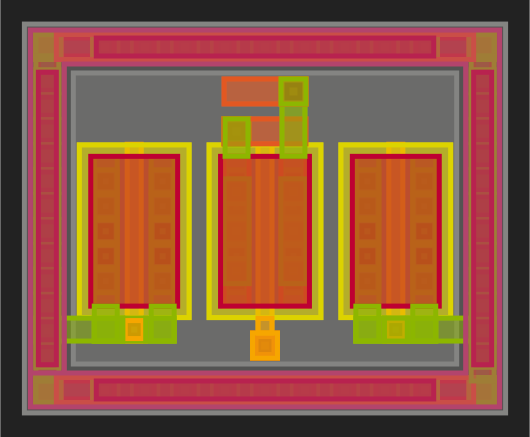

In [47]:
top_level = Component(name="differential_pair")
pdk = diff_pair_config["pdk"]    

M1 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **M1_kwargs)
M2 = nmos(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, **M2_kwargs)

M1_ref = top_level << M1
M2_ref = top_level << M2

M1_ref.name="M1"
M2_ref.name="M2"

display_component(top_level, scale = 5)
## If you want to save the gds file at this stage
#primary_gds = top_level.write_gds("before_placement.gds")


### Placement

In [51]:
placement=diff_pair_config["placement"]
ref_dimensions = evaluate_bbox(M1)

### Routing 

In [ ]:
viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.

#we need four such vias
drain_P_via = top_level << viam2m3
source_P_via = top_level << viam2m3
gate_P_via = top_level << viam2m3

drain_N_via = top_level << viam2m3
gate_N_via = top_level << viam2m3